In [2]:
import json
import datetime
import pandas as pd
import numpy as np
!pip install patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline


  Using cached https://files.pythonhosted.org/packages/ea/0c/5f61f1a3d4385d6bf83b83ea495068857ff8dfb89e74824c6e9eb63286d8/patsy-0.5.1-py2.py3-none-any.whl


C:\Users\n_sri\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
with open('MLand Stats Data Set.json') as json_file:
    data = json.load(json_file)

In [4]:
logins = data['login_time']

In [5]:
len(logins)

97423

In [6]:
print(logins[0:10])

['2010-01-01 00:11:52', '2010-01-01 00:13:00', '2010-01-01 00:14:49', '2010-01-01 00:21:00', '2010-01-01 00:23:05', '2010-01-01 00:29:00', '2010-01-01 00:30:00', '2010-01-01 00:30:36', '2010-01-01 00:32:00', '2010-01-01 00:33:00']


In [7]:
df = pd.DataFrame(data)

In [8]:
df.isnull().sum()

login_time    0
dtype: int64

In [9]:
df = pd.to_datetime(df['login_time'])

In [10]:
df = pd.DataFrame(df)
cnts = np.ones((df.shape[0],), dtype=int)
df['counts'] = cnts
df = df.set_index('login_time')
df.head()

,counts
login_time,
2010-01-01 00:11:52,1
2010-01-01 00:13:00,1
2010-01-01 00:14:49,1
2010-01-01 00:21:00,1
2010-01-01 00:23:05,1


In [11]:
dfr = df.resample('15T').sum()
dfr.head()

,counts
login_time,
2010-01-01 00:00:00,3
2010-01-01 00:15:00,3
2010-01-01 00:30:00,7
2010-01-01 00:45:00,7
2010-01-01 01:00:00,5


In [53]:
dfr_6h = df.resample('6H').sum()
dfr_6h.head()

,counts
login_time,
2010-01-01 00:00:00,104
2010-01-01 06:00:00,44
2010-01-01 12:00:00,115
2010-01-01 18:00:00,82
2010-01-02 00:00:00,43


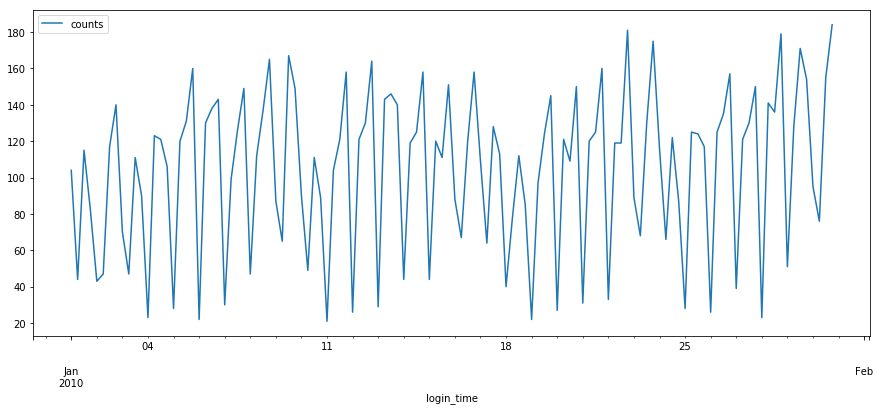

In [54]:
dfr_6h.head(4*30).plot(figsize=(15,6))
plt.show()

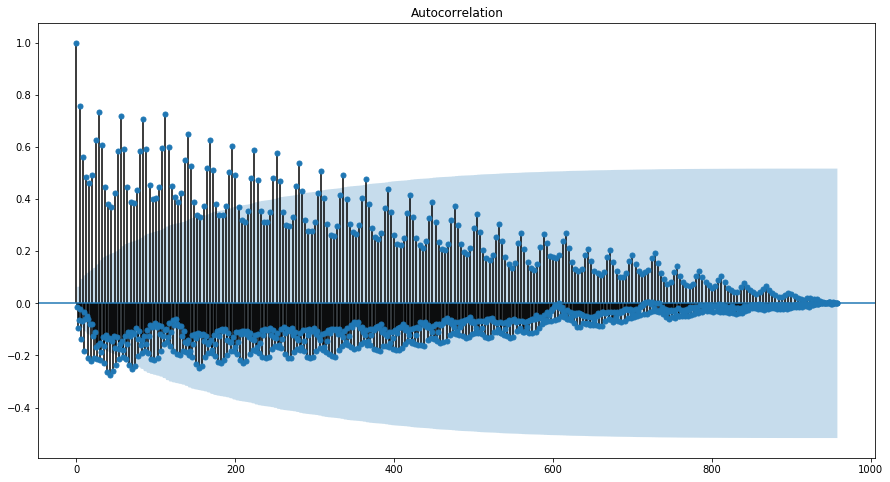

In [55]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_acf = plot_acf((dfr_6h["counts"]))
fig_acf.set_size_inches(15, 8)

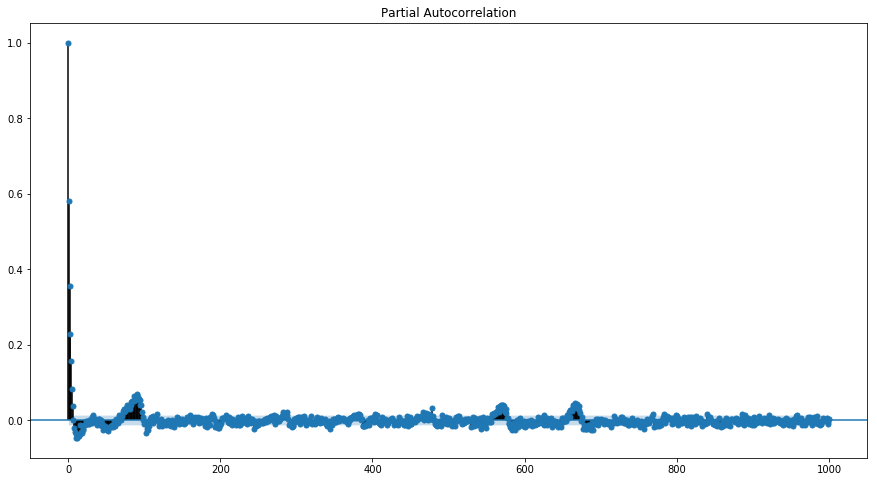

In [37]:
fig_pacf = plot_pacf((dfr["counts"]+1).apply(np.log), lags=1000)
fig_pacf.set_size_inches(15, 8)

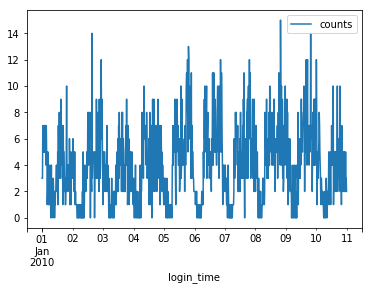

In [16]:
dfr_tendays = dfr.head(960)
dfr_tendays.plot()

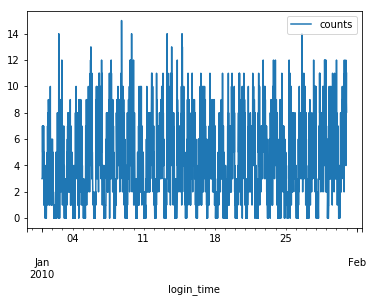

In [20]:
dfr_tenweeks = dfr.head(96*10*3)
dfr_tenweeks.plot()

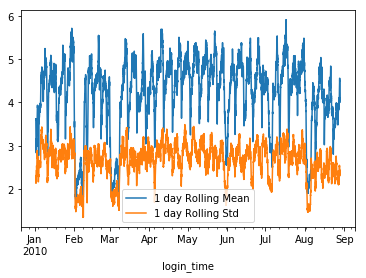

In [26]:
timeseries = dfr['counts']
timeseries.rolling(96).mean().plot(label='1 day Rolling Mean')
timeseries.rolling(96).std().plot(label='1 day Rolling Std')
#timeseries.plot()
plt.legend()

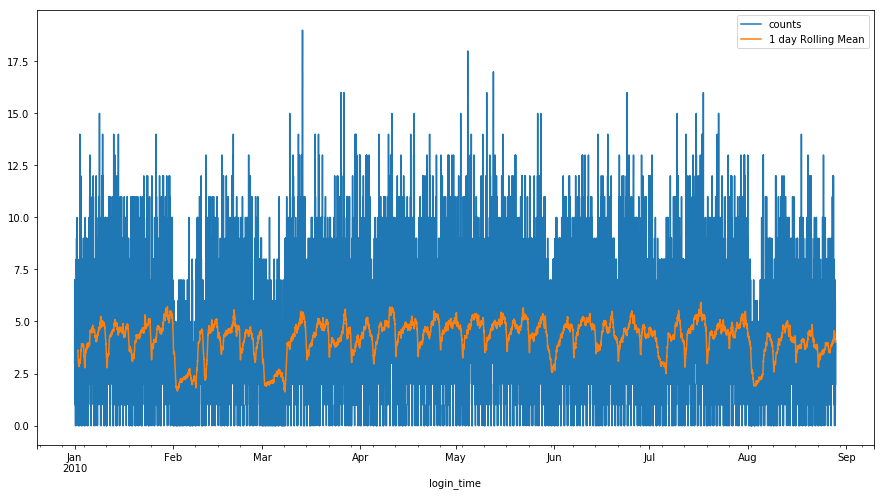

In [18]:
fig = plt.figure()  
timeseries.plot()
timeseries.rolling(96).mean().plot(label='1 day Rolling Mean')
plt.legend()
fig.set_size_inches(15, 8)

In [15]:
from statsmodels.tsa.stattools import adfuller

In [23]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series,maxlag=150)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [24]:
adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.976212404721388
p-value : 8.415878917491158e-10
#Lags Used : 129
Number of Observations Used : 22874
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
dfr_train = pd.DataFrame()
dfr_train['y'] = dfr['counts'].head(23000)
dfr_train['ds'] = dfr_train.index
dfr_test = pd.DataFrame()
dfr_test['y'] = dfr['counts'].tail(4)
dfr_test['ds'] = dfr_test.index

In [ ]:
m = Prophet(daily_seasonality=96, weekly_seasonality=96*7)
#m.add_seasonality(name='monthly', period=28*96, fourier_order=5)
m.fit(dfr_train)
fig = m.plot_components(forecast)

In [ ]:
future = m.make_future_dataframe(periods=8,freq='15T')
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
df = pd.DataFrame()
predicted = np.array(forecast['yhat'].tail(8))
actual = np.array(dfr_test['y'])
rmse = (np.mean((actual-predicted[:4])**2))**0.5
print(rmse)